In [31]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining


app_reviews = pd.read_csv("reviews.csv")

df_app_reviews = pd.DataFrame(app_reviews)

review_counter, column_counter = df_app_reviews.shape


print(review_counter)
print(column_counter)

94500
11


In [32]:
df_app_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ca5ea9e0-2388-4ea4-8c5c-05b54675fe87,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasinya sudah bagus, hanya saja metode pem...",5,49,11.3.0,2025-02-06 11:42:29,NaN,NaN,11.3.0
1,7179d985-57a8-44c1-9dec-e3ae68dfdb29,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Memasuki tahun 2025 BukaLapak jadi semakin mun...,1,30,11.3.0,2025-02-28 13:04:16,NaN,NaN,11.3.0
2,daba1033-9a55-4eaa-9878-a128f87ebb2e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Ketika transaksi pending, komplin ke cs sangat...",1,5,11.3.0,2025-02-27 08:05:14,NaN,NaN,11.3.0
3,78af8a64-91e7-47a0-b1c5-de20f94ffbf6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bukalapak makin gak jelas,pengajuan komplain p...",1,258,11.3.0,2025-01-14 21:53:33,NaN,NaN,11.3.0
4,8df46ba7-a6fa-4728-9e49-5e059d0f0e05,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,dengan ini saya memohon untuk pengembalian dan...,1,21,11.3.0,2025-02-21 15:14:50,NaN,NaN,11.3.0


In [33]:
df_app_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94500 entries, 0 to 94499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              94500 non-null  object
 1   userName              94500 non-null  object
 2   userImage             94500 non-null  object
 3   content               94500 non-null  object
 4   score                 94500 non-null  int64 
 5   thumbsUpCount         94500 non-null  int64 
 6   reviewCreatedVersion  67907 non-null  object
 7   at                    94500 non-null  object
 8   replyContent          26551 non-null  object
 9   repliedAt             26551 non-null  object
 10  appVersion            67907 non-null  object
dtypes: int64(2), object(9)
memory usage: 7.9+ MB


In [34]:
clean_df_app_reviews = df_app_reviews.dropna()
clean_df_app_reviews = clean_df_app_reviews.drop_duplicates()
clean_df_app_reviews = clean_df_app_reviews.drop(columns=["reviewId","userName","userImage","score","thumbsUpCount","reviewCreatedVersion","at","replyContent","repliedAt","appVersion"])

clean_review_counter, clean_column_counter = clean_df_app_reviews.shape

clean_df_app_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20525 entries, 11 to 94491
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20525 non-null  object
dtypes: object(1)
memory usage: 320.7+ KB


Processing Text

In [35]:
%pip install sastrawi nltk wordcloud

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
 
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt_tab to /home/gandhi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gandhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal","gua": "saya","bod*h":"bodoh","henti""":"henti-henti","gada":"tidak ada"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [37]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df_app_reviews['text_clean'] = clean_df_app_reviews['content'].apply(cleaningText)
 
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df_app_reviews['text_casefoldingText'] = clean_df_app_reviews['text_clean'].apply(casefoldingText)
 
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df_app_reviews['text_slangwords'] = clean_df_app_reviews['text_casefoldingText'].apply(fix_slangwords)
 
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df_app_reviews['text_tokenizingText'] = clean_df_app_reviews['text_slangwords'].apply(tokenizingText)
 
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df_app_reviews['text_stopword'] = clean_df_app_reviews['text_tokenizingText'].apply(filteringText)
 
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df_app_reviews['text_akhir'] = clean_df_app_reviews['text_stopword'].apply(toSentence)

In [38]:
clean_df_app_reviews

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
11,Saya top up dana Sudah saya transfer tapi di a...,Saya top up dana Sudah saya transfer tapi di a...,saya top up dana sudah saya transfer tapi di a...,saya top up dana sudah saya transfer tapi di a...,"[saya, top, up, dana, sudah, saya, transfer, t...","[top, up, dana, transfer, aplikasi, masuk, moh...",top up dana transfer aplikasi masuk mohon diba...
24,"Nama kami dulu besar di sini, performa lapak s...",Nama kami dulu besar di sini performa lapak sa...,nama kami dulu besar di sini performa lapak sa...,nama kami dulu besar di sini performa lapak sa...,"[nama, kami, dulu, besar, di, sini, performa, ...","[nama, performa, lapak, bagus, sayangkan, semn...",nama performa lapak bagus sayangkan semnjak vr...
42,mau komplen kemana gak jelas. cuman diarahin k...,mau komplen kemana gak jelas cuman diarahin ke...,mau komplen kemana gak jelas cuman diarahin ke...,mau komplen kemana gak jelas cuman diarahin ke...,"[mau, komplen, kemana, gak, jelas, cuman, diar...","[komplen, kemana, cuman, diarahin, faq, update...",komplen kemana cuman diarahin faq update bukab...
63,Setelah update malah jadi suka error padahal s...,Setelah update malah jadi suka error padahal s...,setelah update malah jadi suka error padahal s...,setelah update malah jadi suka error padahal s...,"[setelah, update, malah, jadi, suka, error, pa...","[update, suka, error, cepat, suka, errorbarusa...",update suka error cepat suka errorbarusan turu...
97,Sudah bertahun² gak pernah dikasih vocer poton...,Sudah bertahun² gak pernah dikasih vocer poton...,sudah bertahun² gak pernah dikasih vocer poton...,sudah bertahun² gak pernah dikasih vocer poton...,"[sudah, bertahun², gak, pernah, dikasih, vocer...","[bertahun², dikasih, vocer, potongan, harga, g...",bertahun² dikasih vocer potongan harga gratis ...
...,...,...,...,...,...,...,...
94481,Masih kalah dengan aplikasi Tokopedia dari seg...,Masih kalah dengan aplikasi Tokopedia dari seg...,masih kalah dengan aplikasi tokopedia dari seg...,masih kalah dengan aplikasi tokopedia dari seg...,"[masih, kalah, dengan, aplikasi, tokopedia, da...","[kalah, aplikasi, tokopedia, fitur]",kalah aplikasi tokopedia fitur
94484,"fitur chat k pelapak nya ga konek, cuma contre...",fitur chat k pelapak nya ga konek cuma contren...,fitur chat k pelapak nya ga konek cuma contren...,fitur chat k pelapak nya ga konek cuma contren...,"[fitur, chat, k, pelapak, nya, ga, konek, cuma...","[fitur, chat, k, pelapak, konek, contreng, dah...",fitur chat k pelapak konek contreng dah berhar...
94488,"Parah nih Bukalapak, masa bukadompet saya di b...",Parah nih Bukalapak masa bukadompet saya di be...,parah nih bukalapak masa bukadompet saya di be...,parah nih bukalapak masa bukadompet saya di be...,"[parah, nih, bukalapak, masa, bukadompet, saya...","[parah, nih, bukalapak, bukadompet, bekukan, a...",parah nih bukalapak bukadompet bekukan ampun s...
94489,Kalo flash deal tentang peralatan sepeda dong ...,Kalo flash deal tentang peralatan sepeda dong ...,kalo flash deal tentang peralatan sepeda dong ...,kalo flash deal tentang peralatan sepeda dong ...,"[kalo, flash, deal, tentang, peralatan, sepeda...","[kalo, flash, deal, peralatan, sepeda, shifter]",kalo flash deal peralatan sepeda shifter


In [39]:
%pip install requests
import csv
import requests
from io import StringIO
 
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

Note: you may need to restart the kernel to use updated packages.


In [40]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
 
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
 
    score = 0
    # Inisialisasi skor sentimen ke 0
 
    for word in text:
        # Mengulangi setiap kata dalam teks
        
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
        elif (word in lexicon_negative):
            score = score + lexicon_negative[word]
        else:
            score = 0
 
    polarity=''
    # Inisialisasi variabel polaritas
 
    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [41]:
results = clean_df_app_reviews['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df_app_reviews['polarity_score'] = results[0]
clean_df_app_reviews['polarity'] = results[1]
print(clean_df_app_reviews['polarity'].value_counts())

polarity
neutral     13153
positive     4447
negative     2925
Name: count, dtype: int64


In [42]:
clean_df_app_reviews

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
11,Saya top up dana Sudah saya transfer tapi di a...,Saya top up dana Sudah saya transfer tapi di a...,saya top up dana sudah saya transfer tapi di a...,saya top up dana sudah saya transfer tapi di a...,"[saya, top, up, dana, sudah, saya, transfer, t...","[top, up, dana, transfer, aplikasi, masuk, moh...",top up dana transfer aplikasi masuk mohon diba...,-4,negative
24,"Nama kami dulu besar di sini, performa lapak s...",Nama kami dulu besar di sini performa lapak sa...,nama kami dulu besar di sini performa lapak sa...,nama kami dulu besar di sini performa lapak sa...,"[nama, kami, dulu, besar, di, sini, performa, ...","[nama, performa, lapak, bagus, sayangkan, semn...",nama performa lapak bagus sayangkan semnjak vr...,0,neutral
42,mau komplen kemana gak jelas. cuman diarahin k...,mau komplen kemana gak jelas cuman diarahin ke...,mau komplen kemana gak jelas cuman diarahin ke...,mau komplen kemana gak jelas cuman diarahin ke...,"[mau, komplen, kemana, gak, jelas, cuman, diar...","[komplen, kemana, cuman, diarahin, faq, update...",komplen kemana cuman diarahin faq update bukab...,4,positive
63,Setelah update malah jadi suka error padahal s...,Setelah update malah jadi suka error padahal s...,setelah update malah jadi suka error padahal s...,setelah update malah jadi suka error padahal s...,"[setelah, update, malah, jadi, suka, error, pa...","[update, suka, error, cepat, suka, errorbarusa...",update suka error cepat suka errorbarusan turu...,0,neutral
97,Sudah bertahun² gak pernah dikasih vocer poton...,Sudah bertahun² gak pernah dikasih vocer poton...,sudah bertahun² gak pernah dikasih vocer poton...,sudah bertahun² gak pernah dikasih vocer poton...,"[sudah, bertahun², gak, pernah, dikasih, vocer...","[bertahun², dikasih, vocer, potongan, harga, g...",bertahun² dikasih vocer potongan harga gratis ...,2,positive
...,...,...,...,...,...,...,...,...,...
94481,Masih kalah dengan aplikasi Tokopedia dari seg...,Masih kalah dengan aplikasi Tokopedia dari seg...,masih kalah dengan aplikasi tokopedia dari seg...,masih kalah dengan aplikasi tokopedia dari seg...,"[masih, kalah, dengan, aplikasi, tokopedia, da...","[kalah, aplikasi, tokopedia, fitur]",kalah aplikasi tokopedia fitur,0,neutral
94484,"fitur chat k pelapak nya ga konek, cuma contre...",fitur chat k pelapak nya ga konek cuma contren...,fitur chat k pelapak nya ga konek cuma contren...,fitur chat k pelapak nya ga konek cuma contren...,"[fitur, chat, k, pelapak, nya, ga, konek, cuma...","[fitur, chat, k, pelapak, konek, contreng, dah...",fitur chat k pelapak konek contreng dah berhar...,0,neutral
94488,"Parah nih Bukalapak, masa bukadompet saya di b...",Parah nih Bukalapak masa bukadompet saya di be...,parah nih bukalapak masa bukadompet saya di be...,parah nih bukalapak masa bukadompet saya di be...,"[parah, nih, bukalapak, masa, bukadompet, saya...","[parah, nih, bukalapak, bukadompet, bekukan, a...",parah nih bukalapak bukadompet bekukan ampun s...,0,neutral
94489,Kalo flash deal tentang peralatan sepeda dong ...,Kalo flash deal tentang peralatan sepeda dong ...,kalo flash deal tentang peralatan sepeda dong ...,kalo flash deal tentang peralatan sepeda dong ...,"[kalo, flash, deal, tentang, peralatan, sepeda...","[kalo, flash, deal, peralatan, sepeda, shifter]",kalo flash deal peralatan sepeda shifter,0,neutral


In [43]:
#create one hot encoding for column polarity label
category = pd.get_dummies(clean_df_app_reviews.polarity)

#concat result from one hot encoding
new_df_app_reviews = pd.concat([clean_df_app_reviews,category],axis=1)

#drop unused column label
new_df_app_reviews = new_df_app_reviews.drop(columns=["content","text_clean","text_casefoldingText","text_slangwords","text_tokenizingText","text_stopword","polarity_score","polarity"])

new_df_app_reviews

,text_akhir,negative,neutral,positive
11,top up dana transfer aplikasi masuk mohon diba...,True,False,False
24,nama performa lapak bagus sayangkan semnjak vr...,False,True,False
42,komplen kemana cuman diarahin faq update bukab...,False,False,True
63,update suka error cepat suka errorbarusan turu...,False,True,False
97,bertahun² dikasih vocer potongan harga gratis ...,False,False,True
...,...,...,...,...
94481,kalah aplikasi tokopedia fitur,False,True,False
94484,fitur chat k pelapak konek contreng dah berhar...,False,True,False
94488,parah nih bukalapak bukadompet bekukan ampun s...,False,True,False
94489,kalo flash deal peralatan sepeda shifter,False,True,False


In [44]:
text = new_df_app_reviews["text_akhir"].values
labels = new_df_app_reviews[["negative","neutral","positive"]].values


In [45]:
%pip install scikit-learn

from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

text_train, text_test, label_train, label_test = train_test_split(text,labels,test_size=0.2)

Note: you may need to restart the kernel to use updated packages.


In [47]:
%pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore


tokenizer = Tokenizer(num_words=5000,oov_token="x")
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)


sequence_train = tokenizer.texts_to_sequences(text_train)
sequence_test = tokenizer.texts_to_sequences(text_test)

pad_sequence_train = pad_sequences(sequence_train)
pad_sequence_test = pad_sequences(sequence_test)


Note: you may need to restart the kernel to use updated packages.


In [48]:
import tensorflow as tf

callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 5,
    min_lr = 1.5e-5
)

callback_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 12,
    verbose = 0,
    mode = "auto",
    baseline = None,
    restore_best_weights = True
)

In [52]:
import tensorflow as tf
import tensorflow.keras.layers as ly # type: ignore
tf.keras.backend.clear_session()


model = tf.keras.models.Sequential([
    ly.Embedding(input_dim=20000,output_dim=64),
    ly.Dropout(0.5),
    ly.LSTM(64),
    ly.Dropout(0.3),
    ly.Dense(3,activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    pad_sequence_train,
    label_train,
    epochs=2,
    batch_size=128,
    callbacks=[callback_reduce_lr,callback_early_stop],
    verbose=1,
    validation_data=(pad_sequence_test,label_test)

)

Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.6232 - loss: 0.9126 - val_accuracy: 0.8241 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8581 - loss: 0.4081 - val_accuracy: 0.9401 - val_loss: 0.2021 - learning_rate: 0.0010


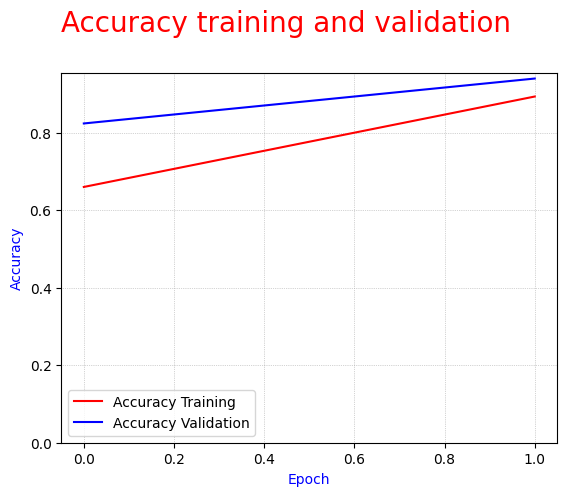

<Figure size 640x480 with 0 Axes>

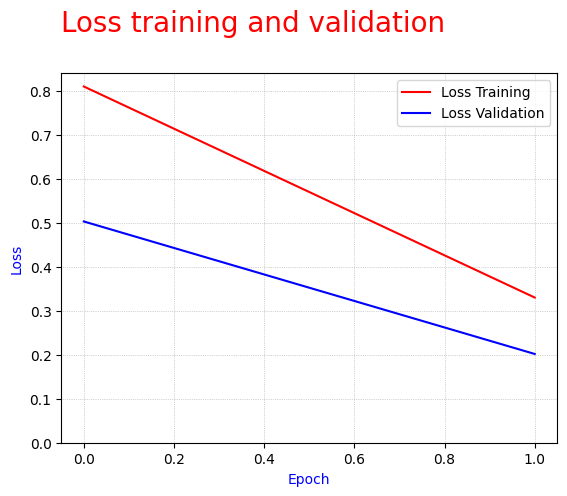

<Figure size 640x480 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs,accuracy,'r',label="Accuracy Training")
plt.plot(epochs,val_accuracy,'b',label="Accuracy Validation")
plt.title('Accuracy training and validation',loc='left',pad=30,fontsize=20,color='red')
plt.ylabel('Accuracy',color = 'blue')
plt.xlabel('Epoch',color = 'blue')
plt.legend(loc=0)
plt.grid(color='darkgray',linestyle=':',linewidth=0.5)
plt.ylim(ymin=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Loss Training")
plt.plot(epochs,val_loss,'b',label="Loss Validation")
plt.title('Loss training and validation',loc='left',pad=30,fontsize=20,color='red')
plt.ylabel('Loss',color = 'blue')
plt.xlabel('Epoch',color = 'blue')
plt.legend(loc=0)
plt.grid(color='darkgray',linestyle=':',linewidth=0.5)
plt.ylim(ymin=0)
plt.figure()
plt.show()